In [25]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re



This script performs the analysis of CRC sequence data from CBioPortal and returns the APC genotype of the samples included, and Figure 1C.

The data used was downloaded from CBioPortal as of 1st of September 2023. The combined study contains samples from 13 studies:
- Colon Adenocarcinoma (CaseCCC, PNAS 2015)
- Colon Cancer (CPTAC-2 Prospective, Cell 2019)
- Colorectal Adenocarcinoma (DFCI, Cell Reports 2016)
- Colorectal Adenocarcinoma (Genentech, Nature 2012)
- Colorectal Adenocarcinoma (TCGA, Firehose Legacy)
- Colorectal Adenocarcinoma (TCGA, Nature 2012)
- Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)
- Colorectal Adenocarcinoma Triplets (MSK, Genome Biol 2014)
- Colorectal Cancer (MSK, JCO Precis Oncol 2022)
- Colorectal Cancer (MSK, Gastroenterology 2020)
- Colon Cancer (Sidra-LUMC AC-ICAM, Nat Med 2023)
- Colorectal Cancer (MSK, Cancer Discovery 2022)
- GENIE Cohort v15.0-public




In [26]:
# Import data

CBio_data= pd.read_csv("CBio_01_09_2023.csv",sep='\t')
CBio_muts=pd.read_csv("mutations_CBio_0923.txt",sep='\t')
CBio_cna=pd.read_csv("cna_CBio_0923.txt",sep='\t')
CBio_mutsg=pd.read_csv("mutations_genie.txt",sep='\t')
CBio_cnag=pd.read_csv("cna_genie.txt",sep='\t')

<ipython-input-26-f60e3e7f758b>:3: DtypeWarning: Columns (46,47,49,59,69,89,90,103,105,114,117,118,119,120,123,141,150,154,156,157,158,160,161,164,171,197,219,222,224,226,228,231,233,235,237,238,239,240,241,243,244,245,246,248) have mixed types. Specify dtype option on import or set low_memory=False.
  CBio_data= pd.read_csv("CBio_01_09_2023.csv",sep='\t')


In [27]:
# Define functions to perform analysis

def extract_numbers(text):
    return [int(match) for match in re.findall(r'\d+', text)]

def find_truncating(n):
    new=[]
    for m in n:
        if '*' in m:
            new.append(m)
    return new

def adapt(muts):
    if max(muts)==2 and min(muts)==0:
        muts=[0,2]
    elif min(muts)==0 and 1 in muts:
        muts=muts[0:2]
    elif max(muts)==0:
        muts=[0,0]
    elif 4 in muts:
        muts=muts[0:2]
    else:
        muts=muts[1:3]
    return muts

def check_search_strings(row, search_strings):
    return any(row.str.contains(search_string).any() for search_string in search_strings)

In [28]:
## Analyse APC mutation data

# Combine mtuation and copy-number data from different studies

CBio_muts = pd.concat([CBio_muts, CBio_mutsg], ignore_index=True)
CBio_cna = pd.concat([CBio_cna, CBio_cnag], ignore_index=True)

# Combine the mtuation and copy-number alteration data

CBio_muts['CN']=CBio_cna['APC']
CBio_muts['CN']=CBio_muts['CN'].fillna('NP')

# Drop duplicate samples across different studies

CBio_muts = CBio_muts.drop_duplicates(subset=['SAMPLE_ID'])
print('All CRCs, n=', len(CBio_muts))


# Filter for APC mutant

CBio_muts=CBio_muts[CBio_muts['APC']!='WT']
print('APC mutant, n=', len(CBio_muts))



# Label deep deletions as deletions 

replacement_dict = {'-2': '-1'}
CBio=CBio_muts.replace(replacement_dict, inplace=True)
CBio=CBio_muts.reset_index(drop=True)

# Find all mutations in APC and store them as arrays

arrays= [string.split() for string in CBio['APC']]
CBio['Mutations']=arrays
CBio['CN']=CBio['CN'].fillna('NP')

# Search for truncating mutations (frameshift and nonsense) and store them separately

new=[]
for m in CBio['Mutations']:
    n=find_truncating(m)
    new.append(find_truncating(m))
    
CBio['Truncating']=new


# For all truncating mutations, classify them by APC region and store the codon position of the first two mutations

strings = ['fs*' + str(n) for n in range(99, 1,-1)]
alls=[]

mutations1=np.zeros(len(CBio))
mutations2=np.zeros(len(CBio))

for i in np.arange(len(CBio)):
    mutations=[]
    k=0
    muts=np.zeros(2)
    for m in CBio['Truncating'][i]:
        m=extract_numbers(m)
        m=np.asarray(m)[0]
        if k<2:
            muts[k]=m
        k+=1
        
        if m<1258:
            region=0
        elif m< 1370:
            region=1
        elif m< 1486:
            region=2
        elif m< 1575:
            region=3
        else:
            region=4
        mutations.append(region)
        
    mutations=sorted(mutations)
    muts=sorted(muts)
    mutations1[i]=muts[0]
    mutations2[i]=muts[1]
    if len(mutations)>2:
        mutations=adapt(mutations)
    alls.append((mutations))

CBio['Genotype']=alls
cs=[]
for c in np.arange(len(CBio)):
    if len(CBio['Genotype'][c])<1:
        cs.append(c)
    

        
CBio=CBio.drop(cs)
CBio=CBio.reset_index(drop=True)
print('Truncating mutations upstream SAMP, n=',len(CBio))


All CRCs, n= 4308
APC mutant, n= 3194
Truncating mutations upstream SAMP, n= 2562


In [29]:
## Analyse copy-number and mutation data data and find the number of 20AARs

CBio['CN']=CBio['CN'].astype(str)
Genotype=[]
aars=[]
for c in np.arange(len(CBio)):
    
    # if there is no copy- number alteration
    
    if CBio['CN'][c] in ['NP','0','0.0']:
        CBio['CN'][c]='0'
        
        # if there are two mutations
        if len(CBio['Genotype'][c])==2:
            Genotype.append(np.asarray(CBio['Genotype'][c]))
            aars.append(sum(CBio['Genotype'][c]))
            
        # if there is a single mutation
        elif len(CBio['Genotype'][c])==1:
            CBio['CN'][c]='SM'

            

    elif CBio['CN'][c] in ['-1','-2','-1.0','-2.0']:
        CN='DelLOH'
        CBio['CN'][c]='-1'
        Genotype.append(np.asarray(CBio['Genotype'][c]))
        aars.append(max(CBio['Genotype'][c]))
            
    elif CBio['CN'][c] in['1.0', '1']:
        CN='CNLOH'
        CBio['CN'][c]='1'

        if len(CBio['Genotype'][c])==1:
            aars.append(2*CBio['Genotype'][c][0])
            Genotype.append(np.asarray(CBio['Genotype'][c]))

        else:
            aars.append(sum(CBio['Genotype'][c]))
            Genotype.append(np.asarray(CBio['Genotype'][c]))

    else:
        nt+=1
    
# Remove tumours with a single APC mutation
CBio = CBio[CBio['CN'] != 'SM']
CBio.reset_index(drop=True)

# Save APC genotype and number of 20AARs 
CBio['20AARs']=aars
CBio['Genotype']=Genotype

print('Samples with no copy-number alterations, n=',len(CBio))


Samples with no copy-number alterations, n= 1305


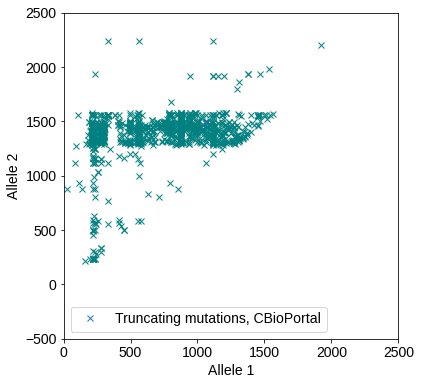

In [38]:
## Plot Figure 1C (CBioPortal Data)


# plot double mutants inly
mutations2=mutations2[mutations1>0]
mutations1=mutations1[mutations1>0]


plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.xlim([0,2500])
plt.ylim([-500,2500])
plt.xlabel('Allele 1', family='Liberation Sans')
plt.ylabel('Allele 2',family='Liberation Sans')


for i in np.arange(len(mutations1)):
    if mutations1[i]>0:
        plt.plot(mutations1[i],mutations2[i],'x',color='teal')
        
plt.plot(mutations1[0],mutations2[0],'x',label='Truncating mutations, CBioPortal')

plt.legend()

plt.savefig('fig1Ca.png', transparent=True,dpi=300)

In [39]:
## Analyse clinical data 

df = CBio_data

# Strings to search for
msi = ['MSI', 'MSI-high','MSI-H', 'msi','MSI-High','Instable']
pole = ['Hypermutated']

# Find sample IDs ohypermutant tumours (msi and pole)
ids_mutated= list(df['Sample ID'][df.apply(check_search_strings, axis=1, args=(pole,))]+df['Sample ID'][df.apply(check_search_strings, axis=1, args=(msi,))])

CBio_MSS=CBio[~CBio['SAMPLE_ID'].isin(ids_mutated)]


In [40]:
## Save data for analysis of MSS tumours with no copy-number alterations

# Remove hypermutated tumours
CBio_MSS=CBio[~CBio['SAMPLE_ID'].isin(ids_mutated)]

# Keep only tumours without copy-number alterations
CBio_MSS_no_cn=CBio_MSS[CBio_MSS['CN']=='0']

CBio_MSS_no_cn['Type'] = CBio_MSS_no_cn['Genotype'].apply(tuple)


# Generate summary frequency table

CBio_MSS_no_cn_ft = CBio_MSS_no_cn.groupby(['Type', 'CN']).size().reset_index(name='Counts')


types=[(0, 0), (1, 1), (2, 2), (3, 3), (0, 1), (1, 2), (1, 3), (0, 2), (2, 3), (0, 3)]
CBio_MSS_no_cn_ft=CBio_MSS_no_cn_ft[CBio_MSS_no_cn_ft['Type'].isin(types)]

print('MSS CRCs classified for analysis, n=', sum(CBio_MSS_no_cn_ft['Counts']))

CBio_MSS_no_cn_ft.to_csv('CBio_Data_MSS_no_cn.csv')

MSS CRCs classified for analysis, n= 1041


<ipython-input-40-b1810ebb1bb9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBio_MSS_no_cn['Type'] = CBio_MSS_no_cn['Genotype'].apply(tuple)
